In [139]:
import urllib.request, json 
import pandas as pd

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data_USDT_BTC = json.loads(url.read().decode())
print("USDT_BTC downloaded")
    
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_ETH = json.loads(url.read().decode())
print("BTC_ETH downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_XRP = json.loads(url.read().decode())
print("BTC_XRP downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_LTC = json.loads(url.read().decode())
print("BTC_LTC downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_XMR = json.loads(url.read().decode())
print("BTC_XMR downloaded")

with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1483228800&end=1539547200&period=300") as url:
    data_BTC_DASH = json.loads(url.read().decode())
print("BTC_DASH downloaded")

print(data_USDT_BTC[0])

df = pd.DataFrame(data=data_USDT_BTC, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['BTC_ETH'] = pd.DataFrame(data=data_BTC_ETH, columns=['weightedAverage']).iloc[:, 0]
df['BTC_XRP'] = pd.DataFrame(data=data_BTC_XRP, columns=['weightedAverage']).iloc[:, 0]
df['BTC_LTC'] = pd.DataFrame(data=data_BTC_LTC, columns=['weightedAverage']).iloc[:, 0]
df['BTC_XMR'] = pd.DataFrame(data=data_BTC_XMR, columns=['weightedAverage']).iloc[:, 0]
df['BTC_DASH'] = pd.DataFrame(data=data_BTC_DASH, columns=['weightedAverage']).iloc[:, 0]
df.head()

USDT_BTC downloaded
BTC_ETH downloaded
BTC_XRP downloaded
BTC_BCH downloaded
BTC_LTC downloaded
BTC_XMR downloaded
BTC_DASH downloaded
{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


,date,weightedAverage,BTC_ETH,BTC_XRP,BTC_BCH,BTC_LTC,BTC_XMR,BTC_DASH
0,1483228800,964.642624,0.008357,0.000007,0.056423,0.004499,0.014309,0.011764
1,1483229100,965.858035,0.008399,0.000007,0.074336,0.004487,0.014311,0.011764
2,1483229400,963.946565,0.008428,0.000007,0.079060,0.004487,0.014362,0.011764
3,1483229700,962.024978,0.008490,0.000007,0.083560,0.004500,0.014367,0.011764
4,1483230000,963.568648,0.008516,0.000007,0.099801,0.004525,0.014369,0.011738


In [84]:
import csv
import numpy as np
import pandas as pd


# df = pd.DataFrame(data=data, columns=['date', 'weightedAverage', 'low', 'high', 'open', 'close', 'quoteVolume'])

# df = df.fillna(method='ffill')
# df.to_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index=False)

# Data already downloaded
# df = pd.read_csv("poloniex_usdt_btc_20170101_DOHLCV_300_indicators.csv", sep=";", index_col=None)

df = pd.read_csv("poloniex_usdt_btc_20170101_DOHLCV_300.csv", sep=";", index_col=None)

df.head()

,date,open,high,low,close,volume
0,1483258800,965.615287,965.615287,962.720039,962.720050,339.976571
1,1483259100,965.615288,965.615288,963.715702,964.000000,2053.800107
2,1483259400,965.584776,965.584776,963.669103,965.584776,26.914038
3,1483259700,963.669114,965.584775,963.669114,965.584775,405.889147
4,1483260000,963.669121,963.669121,963.669121,963.669121,30.485711


In [188]:
# df = df[-60000:]
print(df.shape)

(187729, 11)


In [189]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

In [190]:
# Split the dataset into training (90%), cross validation (5%) and test (5%) set
samples_num = dataset.shape[0]

valid_split = 0.1
test_split = 0.1

dataset_train = dataset[0:int(samples_num * (1-valid_split-test_split))]
dataset_valid = dataset[int(samples_num * (1-valid_split-test_split)):int(samples_num * (1-test_split))]
dataset_test = dataset[int(samples_num * (1-test_split)):samples_num]

print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(150183, 10)
(18773, 10)
(18773, 10)


In [191]:
# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]-2):
        X.append(list(data[i-timesteps:i]))
        
        y.append(sum(data[i:i+2])/2)
        
    X, y = np.array(X), np.array(y)
    return X, y

In [192]:
import numpy as np

timestep = 150 # Make decision from last 'timestep' candles

# Create training examples

train_X, train_y = makeXy(dataset_train, timestep)
valid_X, valid_y = makeXy(dataset_valid, timestep)
test_X, test_y = makeXy(dataset_test, timestep)
    
# train_y = train_y[:, :5]
# valid_y = valid_y[:, :5]
# test_y = test_y[:, :5]
    
print(train_X.shape)
print(train_y.shape)

(150031, 150, 10)
(150031, 10)


In [193]:
train_y = np.expand_dims(train_y, axis=1)
valid_y = np.expand_dims(valid_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)

print(train_X.shape)
print(train_y.shape)

(150031, 150, 10)
(150031, 1, 10)


In [194]:
from sklearn.preprocessing import MinMaxScaler

for i in range(train_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(train_X[i]))
    train_X[i] = scaler.transform(train_X[i])
    train_y[i] = scaler.transform(train_y[i])
    
for i in range(valid_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(valid_X[i]))
    valid_X[i] = scaler.transform(valid_X[i])
    valid_y[i] = scaler.transform(valid_y[i])
    
for i in range(test_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(test_X[i]))
    test_X[i] = scaler.transform(test_X[i])
    test_y[i] = scaler.transform(test_y[i])


In [195]:
print(train_X.shape)
print(train_y.shape)

print(train_X[0])
print(train_y[0])

(150031, 150, 10)
(150031, 1, 10)
[[3.77540414e-01 2.95748369e-01 3.62014419e-01 ... 1.15477518e-01
  8.78477246e-01 8.21260554e-02]
 [4.40882436e-01 3.67413614e-01 3.62014525e-01 ... 9.29022668e-04
  8.80983921e-01 8.20948998e-02]
 [3.25214339e-01 3.67412868e-01 2.59746107e-01 ... 0.00000000e+00
  9.85082231e-01 8.20948998e-02]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 4.24656262e-01
  2.42108052e-01 6.33485996e-01]
 [9.01353412e-01 8.88391145e-01 9.07112300e-01 ... 2.91898922e-01
  2.36034971e-01 6.32769418e-01]
 [9.42166094e-01 9.34566639e-01 8.38974473e-01 ... 2.75176514e-01
  2.03203652e-01 6.32208618e-01]]
[[ 0.92173938  0.9114789   0.79154995  0.92364338  0.0328234   0.08480255
  -0.025       0.16759569  0.25534451  0.60278219]]


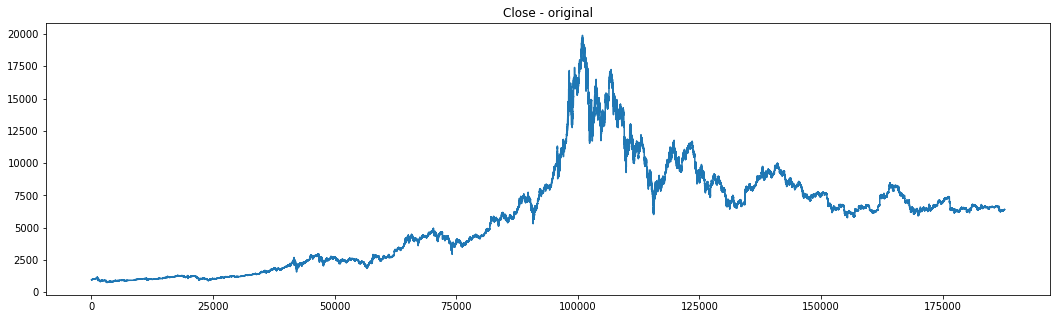

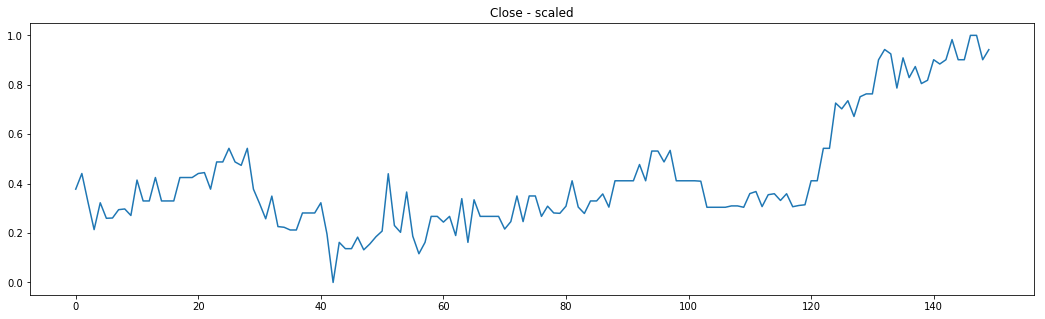

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Close - original')
plt.plot(dataset[:,0])
plt.show()

plt.figure(figsize=(18, 5))
plt.title('Close - scaled')
plt.plot(train_X[0,:,0])
plt.show()

In [197]:
import tensorflow as tf
from keras import backend as K

num_cores = 6

num_CPU = 1
num_GPU = 1

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Dropout, Conv1D, Flatten, MaxPooling1D, LSTM, BatchNormalization, Input, Lambda, TimeDistributed, CuDNNLSTM
from keras import regularizers
from tensorflow import set_random_seed

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

In [198]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [199]:
# train_X = np.expand_dims(train_X, axis=2)
print(train_X.shape)
print(train_y.shape)

train_y = train_y.reshape(-1,train_X.shape[2])
valid_y = valid_y.reshape(-1,train_X.shape[2])
test_y = test_y.reshape(-1,train_X.shape[2])

print(train_y[0].shape)

(150031, 150, 10)
(150031, 1, 10)
(10,)


In [200]:
# Create model
model = Sequential()

# model.add(Conv1D(kernel_size = (3), filters = 64, input_shape=train_X[0].shape, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Conv1D(kernel_size = (3), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Dense(512, activation='relu'))
# model.add(LSTM(128, input_shape=train_X[0].shape))
# # model.add(Flatten(input_shape=train_X[0].shape))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# 0.0037
# model.add(LSTM(128, return_sequences = True, input_shape = train_X[0].shape))
# model.add(TimeDistributed(Dense(1)))
# model.add(LSTM(128, return_sequences = True))
# model.add(TimeDistributed(Dense(1)))
# model.add(LSTM(64))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# model.add(LSTM(128, input_shape=train_X[0].shape))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

model.add(CuDNNLSTM(128, return_sequences=True, input_shape=train_X[0].shape))
model.add(TimeDistributed(Dense(10)))
model.add(CuDNNLSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(train_y[0].shape[0]))
model.add(Activation('linear'))

# Kurva jó első próbálkozás
# model.add(LSTM(128, input_shape=train_X[0].shape))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# # model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.3))
# # model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# last_timestep = Lambda(lambda x: x[:, -1, :])(lstm_layer)

# inputs = Input(shape=train_X[0].shape)
# x = LSTM(128, return_sequences = True, stateful=True, batch_input_shape=(2048, 250, train_X[0].shape))(inputs) # batch_input_shape=(batch_size, timesteps, data_dim)
# # x = Lambda(lambda x : x[:,::5,:])(x) # Last 200 return_sequences of lstm layer
# x = LSTM(64, return_sequences = True, stateful=True)(x)
# x = LSTM(64, stateful=True)(x)
# # x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(train_y[0].shape[0])(x)

# model = Model(inputs=inputs, outputs=x)
    

model.compile(loss='mean_squared_error',
              optimizer= Adam())

# model.save('model.h5') # Saving model for prediction


In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_21 (CuDNNLSTM)    (None, 150, 128)          71680     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 150, 10)           1290      
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 128)               71680     
_________________________________________________________________
dense_46 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_47 (Dense)             (None, 10)                1290      
_________________________________________________________________
activation_11 (Activation)   (None, 10)                0         
Total params: 162,452
Trainable params: 162,452
Non-trainable params: 0
_________________________________________________________________


In [202]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [203]:
print(get_model_memory_usage(1024, model))

0.7


In [204]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [205]:
# Training model
model.fit(train_X, train_y,
          batch_size=1024,
          epochs=100,
          validation_data=(valid_X,valid_y), 
          callbacks=[checkpointer, early_stopping, history],
          shuffle= True)

Train on 150031 samples, validate on 18621 samples
Epoch 1/100
150031/150031 [==============================] - 17s 110us/step - loss: 0.0434 - val_loss: 0.0228

Epoch 00001: val_loss improved from inf to 0.02276, saving model to weights.hdf5
Epoch 2/100
150031/150031 [==============================] - 15s 102us/step - loss: 0.0127 - val_loss: 0.0177

Epoch 00002: val_loss improved from 0.02276 to 0.01771, saving model to weights.hdf5
Epoch 3/100
150031/150031 [==============================] - 15s 102us/step - loss: 0.0101 - val_loss: 0.0156

Epoch 00003: val_loss improved from 0.01771 to 0.01561, saving model to weights.hdf5
Epoch 4/100
150031/150031 [==============================] - 15s 102us/step - loss: 0.0092 - val_loss: 0.0149

Epoch 00004: val_loss improved from 0.01561 to 0.01493, saving model to weights.hdf5
Epoch 5/100
150031/150031 [==============================] - 15s 102us/step - loss: 0.0086 - val_loss: 0.0143

Epoch 00005: val_loss improved from 0.01493 to 0.01428, sa

KeyboardInterrupt: 

In [24]:
# Clear GPU memory

# K.clear_session() # Not working here

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

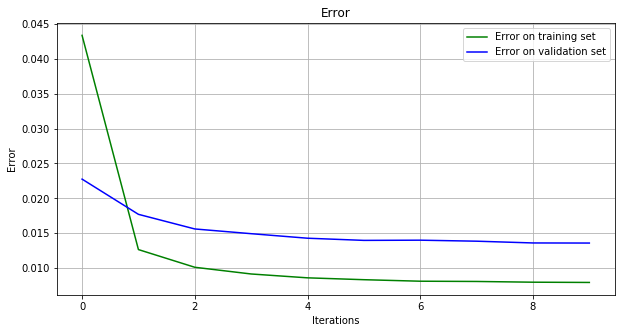

In [206]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title('Error')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [207]:
import sys
from keras.models import load_model
from sklearn.externals import joblib

model.load_weights("weights.hdf5")

pred_data, _ = makeXy(dataset_test, timestep)

prediction_range = 25
prediction_lookback = timestep

predictions = np.zeros(pred_data[0].shape)       
scalers = []
to_predict = []
        
for i in range(0, (pred_data.shape[0]-prediction_range)//prediction_range * prediction_range, prediction_range):    
    r = pred_data[i]
    scaler = MinMaxScaler().fit(r)
    r = scaler.transform(r)

    scalers.append(scaler)
    to_predict.append(r)
    
to_predict = np.array(to_predict)

for candles in range(prediction_range):
    d = to_predict[:, -prediction_lookback:] 
    next = model.predict(d)
    next = np.expand_dims(next, axis=1)
    to_predict = np.append(to_predict, next, axis=1) # Add prediction to known candles

print(to_predict.shape)

for i in range(to_predict.shape[0]):
    inverse_scaled = scalers[i].inverse_transform(to_predict[i, -prediction_range:, :])
    predictions = np.append(predictions, inverse_scaled, axis=0)

(743, 175, 10)


In [208]:
print(predictions.shape)

test_close = pred_data[prediction_lookback:,0, 0]
pred_close = predictions[prediction_lookback:, 0]

print(test_close.shape)
print(pred_close.shape)

(18725, 10)
(18471,)
(18575,)


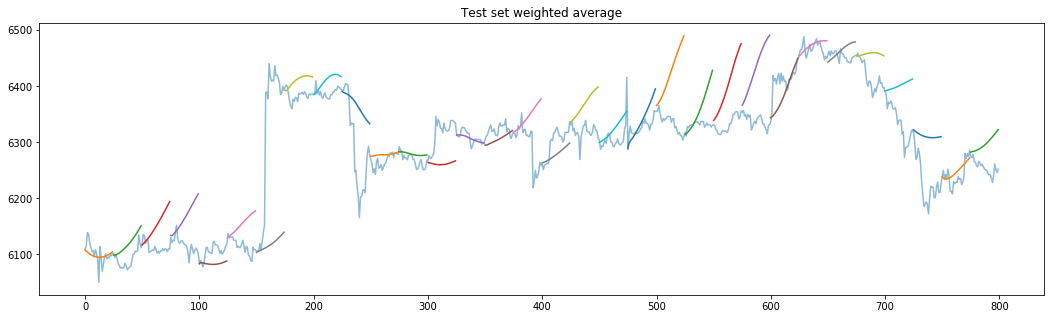

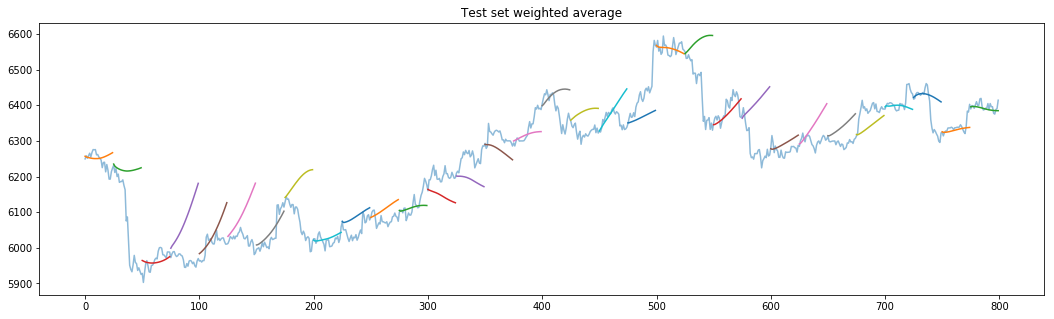

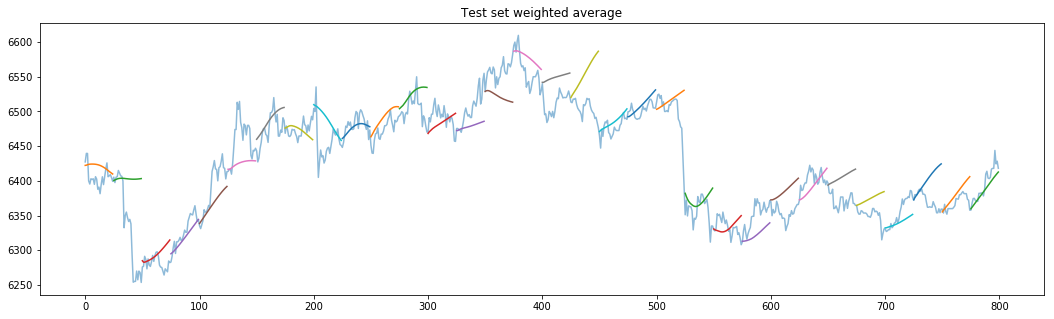

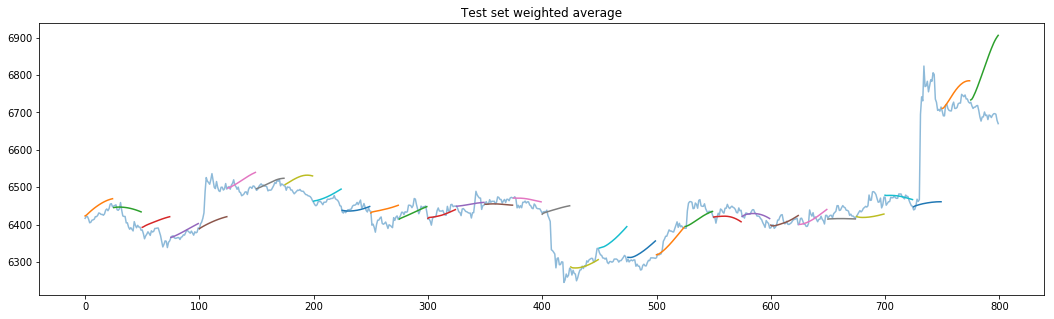

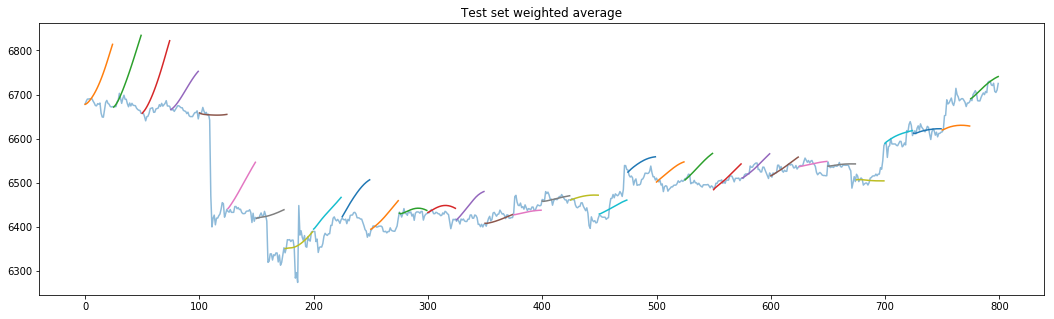

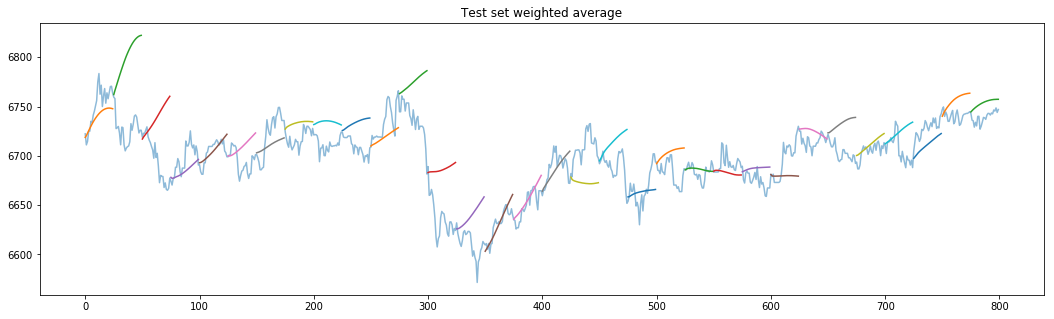

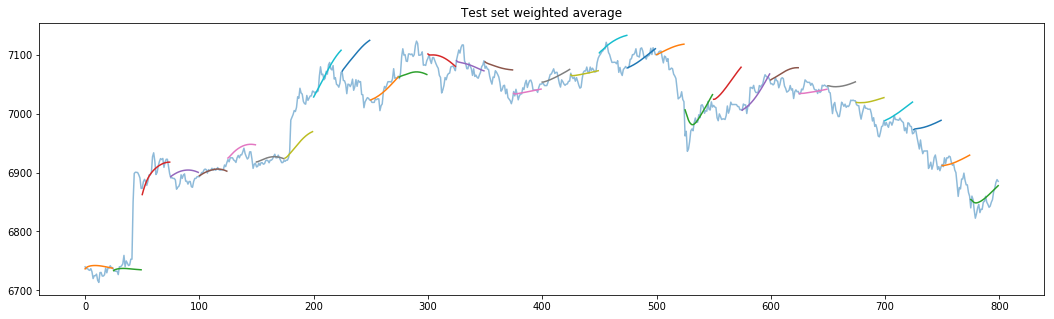

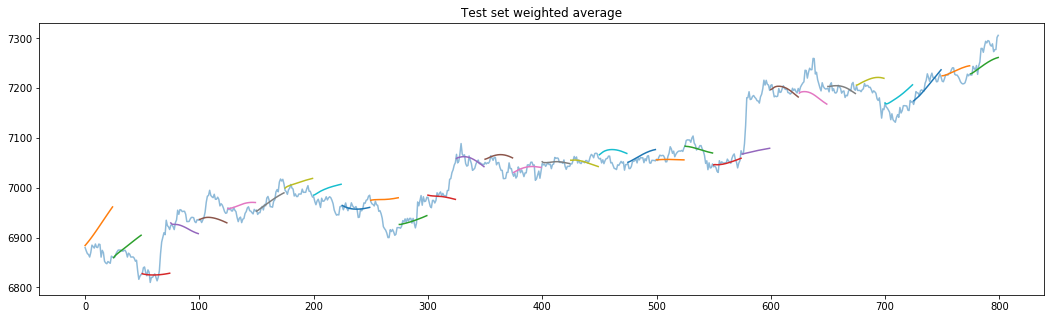

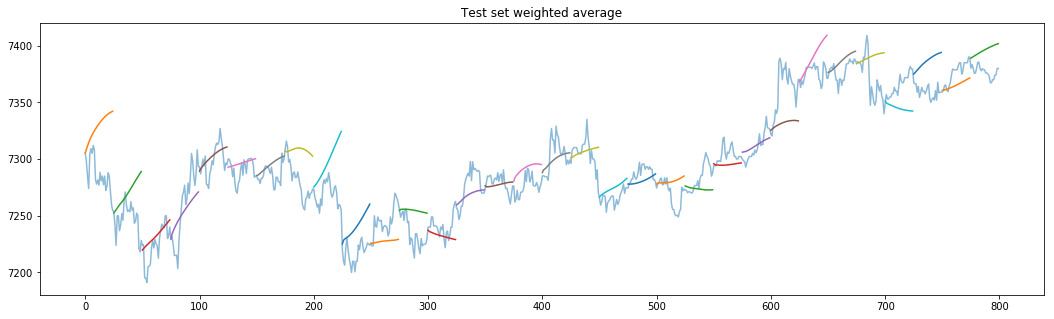

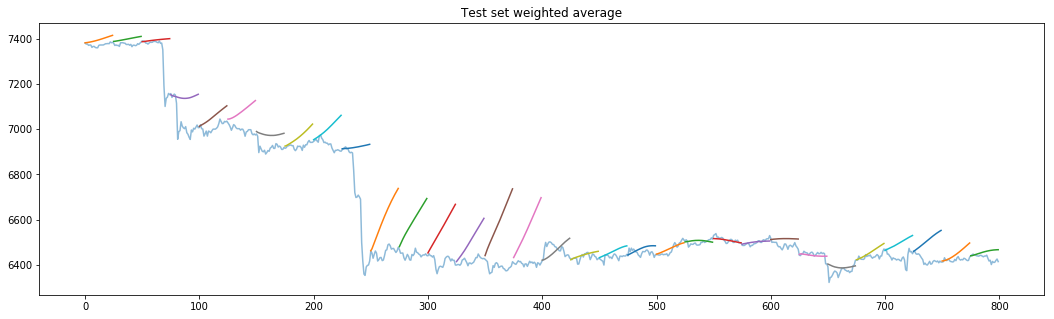

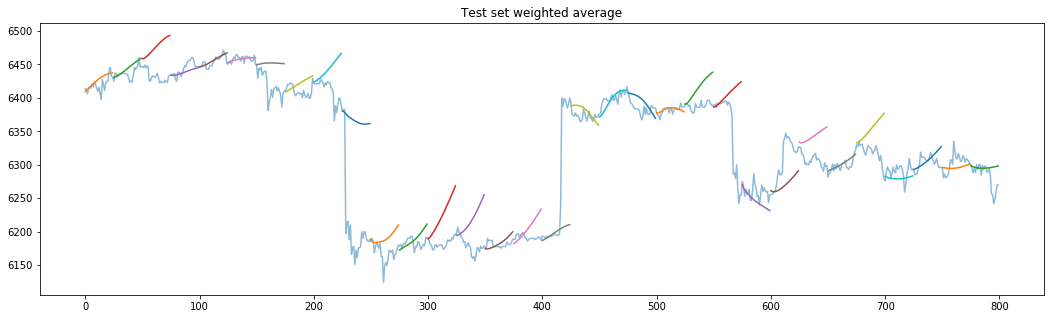

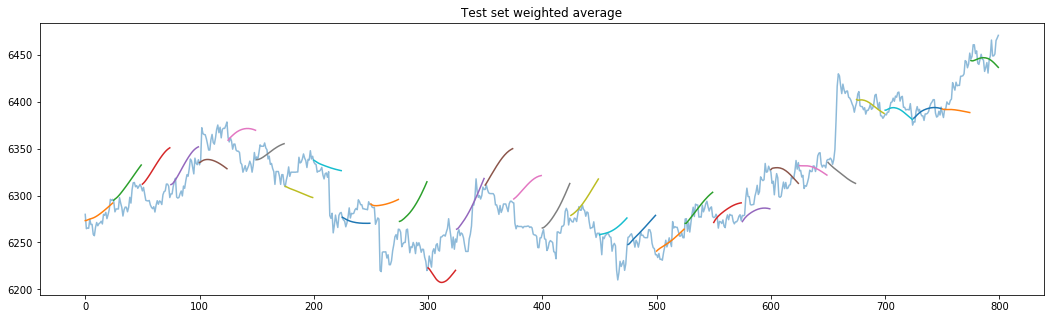

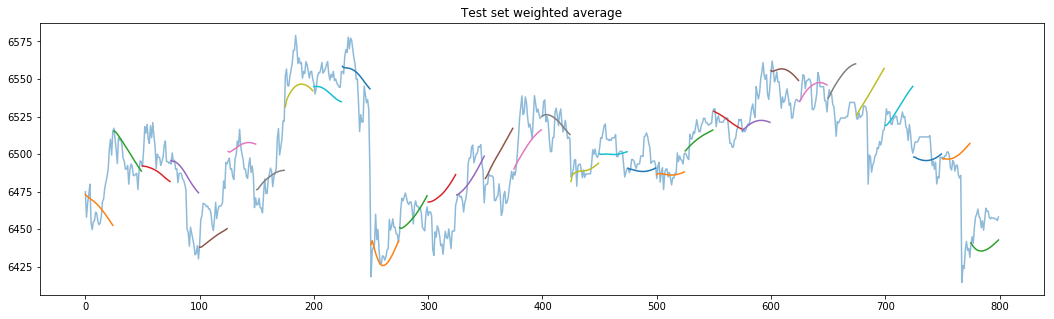

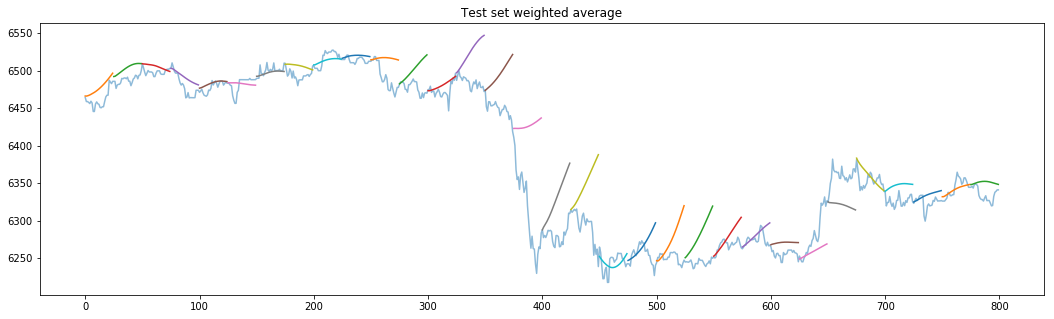

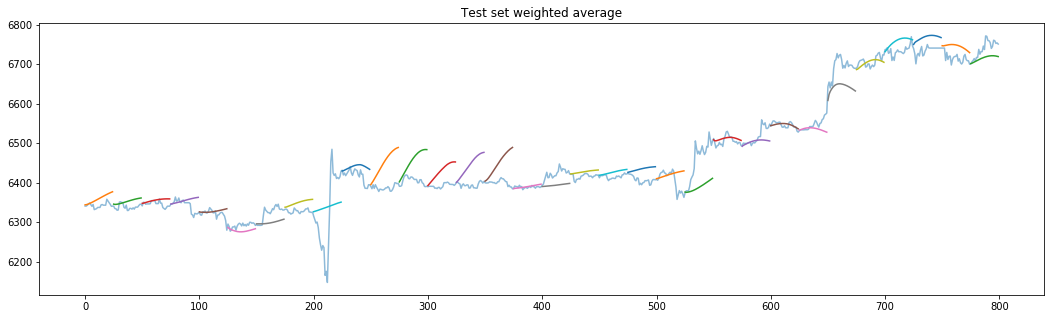

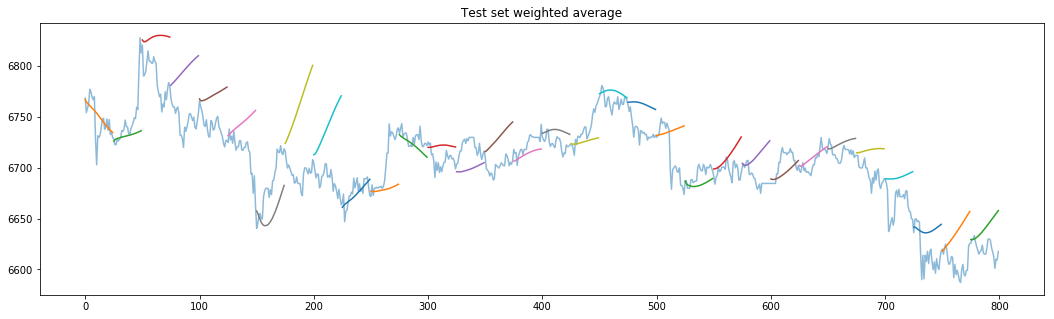

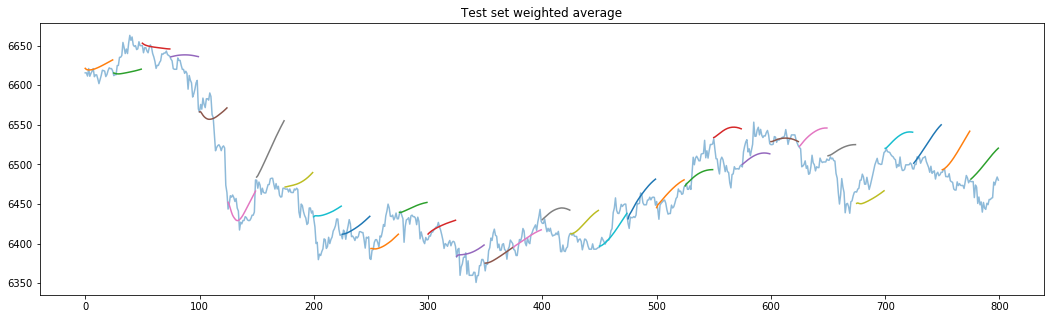

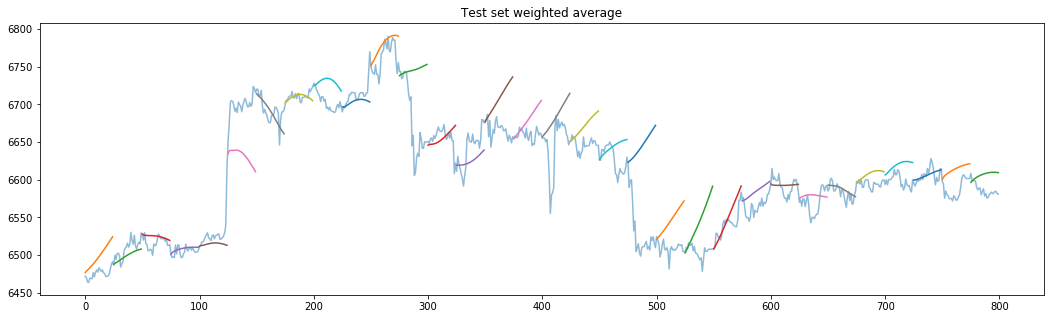

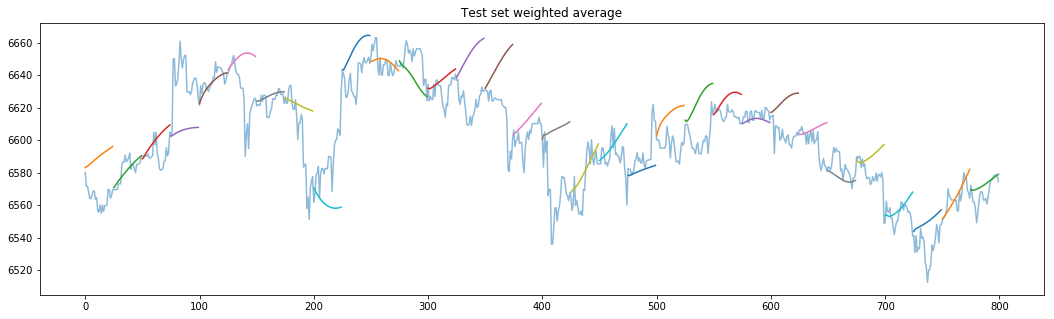

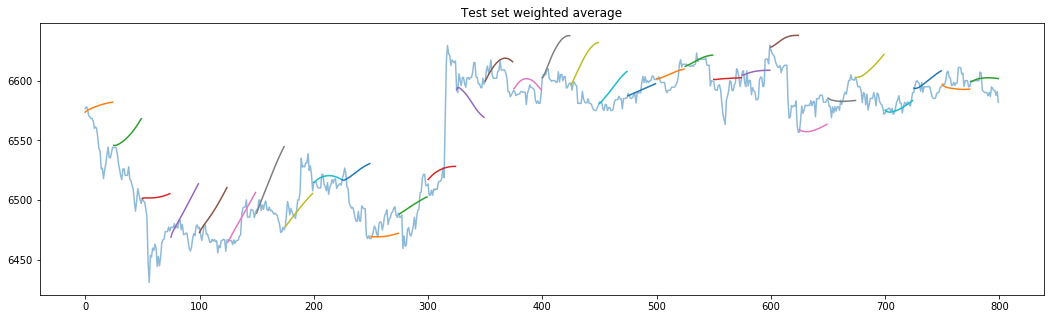

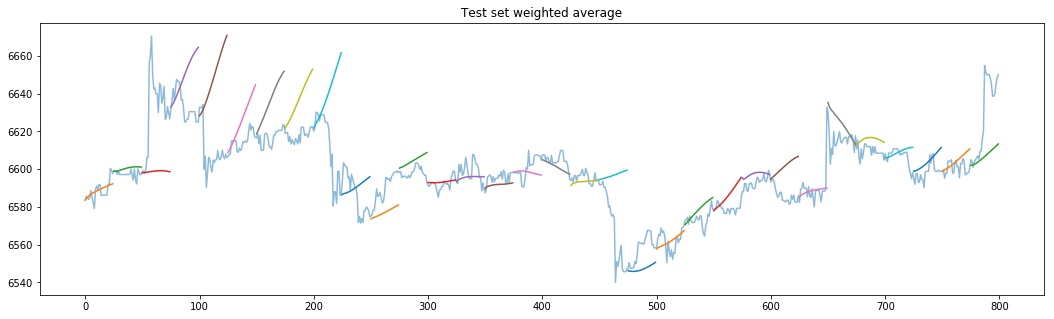

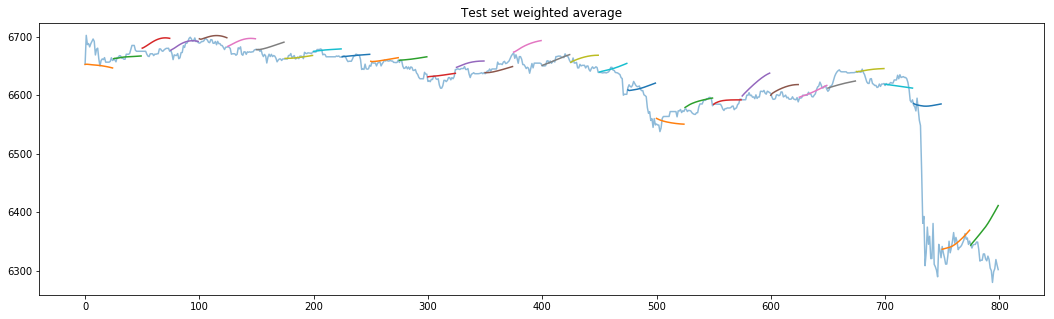

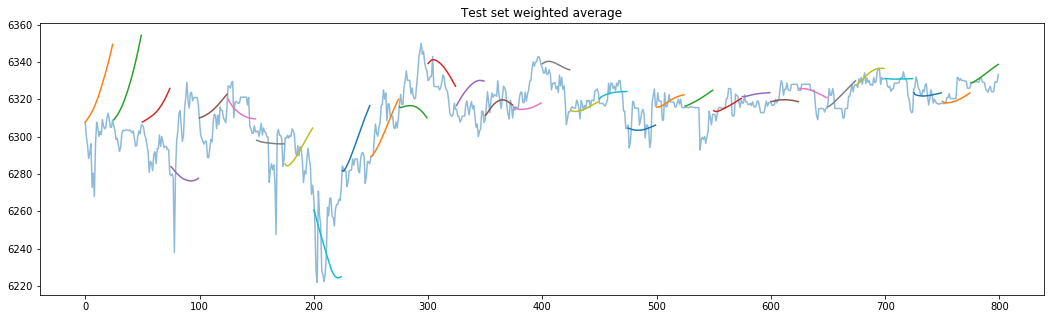

In [209]:
import matplotlib.pyplot as plt

plot_length = 800
number_of_plots = predictions.shape[0] // plot_length

for i in range(number_of_plots):
    
    plt.figure(figsize=(18, 5))
    plt.title('Test set weighted average')
    start = i*plot_length
    end = (i+1)*plot_length
    plt.plot(test_close[start:end], alpha=0.5)
#     plt.plot(test_close[start:end, 1], alpha=0.5)
    for k in range(start, end, prediction_range):
        plt.plot([None for j in range(k-start)] + [x for x in pred_close[k:k+prediction_range]])
    plt.show()